In [3]:
import pandas as pd
from gensim.models import FastText


In [2]:
df = pd.read_hdf("../datasets/TwoXChromosomes.h5", key="TwoXChromosomes")

In [5]:
model_sent = FastText.load("../models/subreddit_level/fasttext_TwoXChromosomes_senti.bin")

In [29]:
NRC = pd.read_csv('../datasets/NRC-VAD-Lexicon.txt', sep="\t", header=None, names=["Words", "valence", "arousal", "dominance"])

In [110]:
token_list = df["token_list"].tolist()
flatlist = [item for sublist in token_list for item in sublist]

In [114]:
def identify_weigths(flat_list):
    from collections import Counter
    female=["sister" , "female" , "woman" , "girl" , "daughter" , "she" , "hers" , "her"]
    male=["brother" , "male" , "man" , "boy" , "son" , "he" , "his" , "him"] 
    
    tokens = [item for sublist in flat_list for item in sublist]
    term_list_woman = []
    for i in tokens:
        if i in female:
            term_list_woman.append(i)
    counter = Counter(term_list_woman)
    
    liste_woman = []
    weights = []
    
    for i in counter:
        if counter[i] > 100:
            liste_woman.append(i)
            weights.append(counter[i])
            
    term_list_man = []
    for i in tokens:
        if i in male:
            term_list_man.append(i)
    counter = Counter(term_list_man)
    
    liste_man = []
    weights_man = []
    
    for i in counter:
        if counter[i] > 100:
            liste_man.append(i)
            weights_man.append(counter[i])
    
    return [liste_woman, weights], [liste_man, weights_man] 

In [115]:
woman_terms_freq, man_terms_freq = identify_weigths(flatlist)

In [116]:
woman_terms_freq, man_terms_freq

([['she', 'woman', 'girl', 'female', 'her', 'daughter', 'sister', 'hers'],
  [127371, 170086, 16913, 12154, 41544, 7337, 5265, 337]],
 [['he', 'his', 'man', 'boy', 'male', 'son', 'brother', 'him'],
  [247152, 57473, 140353, 7640, 17702, 4272, 3778, 344]])

In [117]:
def calculate_centroid_vectors(woman_terms_freq, man_terms_freq, model, NRC, n_words):
    import numpy as np
    word_vectors = model.wv
    centroid_woman = np.ma.average([word_vectors[w] for w in woman_terms_freq[0]], weights= woman_terms_freq[1] ,axis=0)

    vector_woman = word_vectors.similar_by_vector(centroid_woman,topn=n_words)
    
    liste_woman = []
    for i in vector_woman:
        liste_woman.append(i[0])
    
    print("Top 10 (woman)", liste_woman[:10])
    
    intersection_woman = list(set(liste_woman) & set(NRC["Words"]))
    
    intersection_woman_ordererd = []
    for i in vector_woman:
        if i[0] in intersection_woman:
            intersection_woman_ordererd.append(i[0])
    
    df_intersection_woman = pd.DataFrame(intersection_woman_ordererd, columns=["Words"])
    df_intersection_woman = df_intersection_woman.merge(NRC, how="left", left_on="Words", right_on="Words")
    
    
    
    centroid_man = np.ma.average([word_vectors[w] for w in man_terms_freq[0]], weights= man_terms_freq[1] ,axis=0)

    vector_man = word_vectors.similar_by_vector(centroid_man,topn=n_words)
    
    print(vector_man)
    liste_man = []
    for i in vector_man:
        liste_man.append(i[0])
    
    print("Top 10 (man)", liste_man[:10])
    
    intersection_man = list(set(liste_man) & set(NRC["Words"]))
    
    intersection_man_ordererd = []
    for i in vector_man:
        if i[0] in intersection_man:
            intersection_man_ordererd.append(i[0])
    
    df_intersection_man = pd.DataFrame(intersection_man_ordererd, columns=["Words"])
    df_intersection_man = df_intersection_man.merge(NRC, how="left", left_on="Words", right_on="Words")
    
    
    return df_intersection_woman, df_intersection_man, liste_woman, liste_man

In [118]:
df_NRC_woman , df_NRC_man , liste_woman, liste_man= calculate_centroid_vectors(woman_terms_freq, man_terms_freq, model_sent, NRC, 500)


Top 10 (woman) ['she', 'woman', 'her', 'yet', 'herself', 'daughter', 'girl', 'lady', 'man', 'sister']
[('he', 0.9406763911247253), ('guy', 0.8663082718849182), ('his', 0.8518936038017273), ('himself', 0.8368770480155945), ('dude', 0.8190456032752991), ('boyfriend', 0.8107117414474487), ('girlfriend', 0.7952146530151367), ('gf', 0.7936909794807434), ('instantly', 0.7930752635002136), ('bf', 0.7923997044563293), ('would', 0.7732288241386414), ('ass', 0.7718729972839355), ('him', 0.7669090628623962), ('either', 0.7652596831321716), ('let', 0.7651976943016052), ('man', 0.7647193670272827), ('ex', 0.7625066637992859), ('husband', 0.7615591883659363), ('son', 0.7607958316802979), ('wife', 0.7592384219169617), ('clearly', 0.757922351360321), ('immediately', 0.7564546465873718), ('proceed', 0.7560580372810364), ('somehow', 0.7492963075637817), ('she', 0.7462555766105652), ('way', 0.7461507320404053), ('brother', 0.7460767030715942), ('exhusband', 0.7455827593803406), ('sone', 0.744650781154632

In [119]:
len(df_NRC_man)

274

In [120]:
df_NRC_man.sort_values("valence").head()

,Words,valence,arousal,dominance
116,shit,0.000,0.678,0.294
150,afraid,0.010,0.775,0.245
110,hell,0.020,0.918,0.565
167,misbehave,0.020,0.847,0.304
188,disrespectful,0.031,0.694,0.273


In [121]:
df_NRC_man.sort_values("arousal", ascending=False).head()

,Words,valence,arousal,dominance
259,hit,0.235,0.931,0.679
178,fuck,0.198,0.930,0.446
173,stalker,0.177,0.930,0.639
129,aggressively,0.250,0.926,0.688
164,psycho,0.039,0.922,0.560


In [122]:
df_NRC_man.sort_values("dominance", ascending=False).head()

,Words,valence,arousal,dominance
84,boss,0.310,0.627,0.954
48,audacity,0.760,0.755,0.916
223,manager,0.625,0.549,0.897
241,persistence,0.684,0.611,0.873
232,attitude,0.760,0.644,0.861


In [123]:
df_NRC_woman.sort_values("valence").head()

,Words,valence,arousal,dominance
18,afraid,0.010,0.775,0.245
105,hell,0.020,0.918,0.565
173,hate,0.031,0.802,0.430
123,freak,0.052,0.839,0.464
97,shame,0.060,0.670,0.155


In [124]:
df_NRC_woman.sort_values("arousal", ascending=False).head()

,Words,valence,arousal,dominance
64,elated,0.792,0.960,0.725
168,excited,0.908,0.931,0.709
218,aggressively,0.250,0.926,0.688
248,furiously,0.062,0.925,0.657
105,hell,0.020,0.918,0.565


In [125]:
df_NRC_woman.sort_values("dominance", ascending=False).head()

,Words,valence,arousal,dominance
189,boss,0.310,0.627,0.954
86,audacity,0.760,0.755,0.916
205,teacher,0.760,0.404,0.885
259,queen,0.875,0.692,0.860
124,decide,0.656,0.540,0.855


In [126]:
print(df_NRC_man["valence"].var(),df_NRC_man["arousal"].var(),df_NRC_man["dominance"].var() )

0.06436397054891572 0.035926383532525856 0.02843336028448437


In [127]:
print(df_NRC_woman["valence"].var(),df_NRC_woman["arousal"].var(),df_NRC_woman["dominance"].var() )

0.05540919463601533 0.03526120621868553 0.02447201087533157


In [128]:
def check_normal_dist(df,subject, gender):
    import scipy.stats as stats
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline
    from scipy import stats

    z =  (df["valence"]- np.mean(df[subject]))/np.std(df[subject])
    stats.probplot(z, dist="norm", plot=plt)
    plt.title(f"Normal Q-Q plot ({gender})")
    plt.show()

    print("kolmogorv", stats.kstest(df[subject],
               stats.norm.cdf))

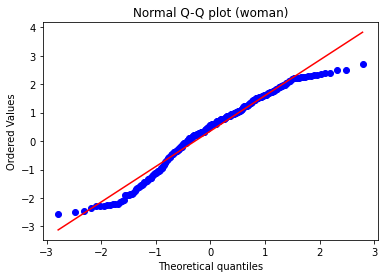

kolmogorv KstestResult(statistic=0.5648545525871953, pvalue=3.9706904101649854e-79)


In [129]:
check_normal_dist(df_NRC_woman, "arousal", "woman")

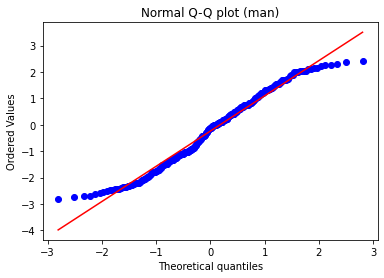

kolmogorv KstestResult(statistic=0.5549963430058545, pvalue=6.4487008890265276e-80)


In [130]:
check_normal_dist(df_NRC_man, "arousal","man")

In [131]:
def apply_welch_test(df_1,df_2,score_type):
    from scipy.stats import ttest_ind
    import math
    import statistics

    stat, p = ttest_ind(df_1[score_type].tolist(),df_2[score_type].tolist(), nan_policy="omit", alternative="two-sided",equal_var=False )#, equal_var=False)
    alpha = 0.05
    print("welsh")
    print("Statistics=%3f, p=%.3f" % (stat, p))
    if p < alpha:
        print("Different distributions (reject H0)")
    else:
        print("Same distribution (fail to reject H0)")
    if p < alpha:
        d = (df_1[score_type].mean() - df_2[score_type].mean())/math.sqrt(((df_1[score_type].var() + df_2[score_type].var())/2))
        
        print(d, "Cohens D")
    print(len(df_1), len(df_2))

In [134]:
apply_welch_test(df_NRC_woman, df_NRC_man,"arousal")
apply_welch_test(df_NRC_woman, df_NRC_man,"valence")
apply_welch_test(df_NRC_woman, df_NRC_man,"dominance")

welsh
Statistics=-2.447189, p=0.015
Different distributions (reject H0)
-0.21164086946776997 Cohens D
261 274
welsh
Statistics=3.362393, p=0.001
Different distributions (reject H0)
0.29055947105156965 Cohens D
261 274
welsh
Statistics=2.176929, p=0.030
Different distributions (reject H0)
0.1881178887473758 Cohens D
261 274


In [133]:
print(df_NRC_man["valence"].mean(),df_NRC_man["arousal"].mean(),df_NRC_man["dominance"].mean() )
print(df_NRC_woman["valence"].mean(),df_NRC_woman["arousal"].mean(),df_NRC_woman["dominance"].mean() )

0.4847992700729925 0.5299671532846716 0.4771970802919713
0.5559042145593871 0.49003831417624544 0.5077931034482759
